# Inpainting with OpenVINO GenAI

inpainting is task of replacing or editing specific area of input image. This makes it a useful tool for image restoration like removing defects and artifacts, or even replacing an image area with something entirely new. Inpainting relies on a mask to determine which regions of an image to fill in; the area to inpaint is represented by white pixels and the area to keep is represented by black pixels. The white pixels are filled in by the prompt.

In this tutorial we consider how to perform inpainting using OpenVINO GenAI.

## About OpenVINO GenAI

[OpenVINO™ GenAI](https://github.com/openvinotoolkit/openvino.genai) is a library of the most popular Generative AI model pipelines, optimized execution methods, and samples that run on top of highly performant OpenVINO Runtime.

This library is friendly to PC and laptop execution, and optimized for resource consumption. It requires no external dependencies to run generative models as it already includes all the core functionality (e.g. tokenization via openvino-tokenizers).

OpenVINO GenAI supports popular diffusion models like Stable Diffusion or SDXL for performing image generation. You can find supported models list in [OpenVINO GenAI documentation](https://github.com/openvinotoolkit/openvino.genai/blob/master/SUPPORTED_MODELS.md#image-generation-models). Previously, we considered how to run [text-to-image](../text-to-image-genai/text-to-image-genai.ipynb) and [image-to-image](../image-to-image-genai/image-to-image-genai.ipynb) generation with OpenVINO GenAI and [apply multiple LoRA adapters](../multilora-image-generation/multilora-image-generation.ipynb), now is inpainting turn. 

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Prepare model](#Prepare-model)
    - [Export OpenVINO IR format model using the Hugging Face Optimum library accelerated by OpenVINO integration.](#Export-OpenVINO-IR-format-model-using-the-Hugging-Face-Optimum-library-accelerated-by-OpenVINO-integration.)
    - [Use optimized models provided on HuggingFace Hub](#Use-optimized-models-provided-on-HuggingFace-Hub)
- [Create inference pipeline](#Create-inference-pipeline)
    - [Prepare input](#Prepare-input)
    - [Run inference pipeline](#Run-inference-pipeline)
- [Mask blur](#Mask-blur)
- [Use non-inpaint specific models](#Use-non-inpaint-specific-models)
- [Configure pipeline parameters](#Configure-pipeline-parameters)
    - [Strength](#Strength)
    - [Guidance Scale](#Guidance-Scale)
    - [Negative prompt](#Negative-prompt)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/inpainting-genai/inpainting-genai.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
import platform
import requests
from pathlib import Path

%pip install -q "git+https://github.com/huggingface/optimum-intel.git" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q -U --pre --extra-index-url https://storage.openvinotoolkit.org/simple/wheels/nightly "openvino>=2024.5" "openvino-tokenizers>=2024.5" "openvino-genai>=2024.5"
%pip install -q Pillow "diffusers>=0.30.3" "gradio>=4.19" "typing_extensions>=4.9" "tqdm" huggingface-hub "nncf>=2.14.0" --extra-index-url https://download.pytorch.org/whl/cpu

if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    open("notebook_utils.py", "w").write(r.text)

if not Path("cmd_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py",
    )
    open("cmd_helper.py", "w").write(r.text)

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("inpainting-genai.ipynb")

## Prepare model
[back to top ⬆️](#Table-of-contents:)


For starting working with OpenVINO GenAI pipelines, we should prepare models for inference. OpenVINO GenAI image generation pipelines accepts diffusers-compatible models converted to OpenVINO Intermediate Representation format using Optimum Intel Interface. 

### Export OpenVINO IR format model using the [Hugging Face Optimum](https://huggingface.co/docs/optimum/installation) library accelerated by OpenVINO integration.
[back to top ⬆️](#Table-of-contents:)

🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 [Transformers](https://huggingface.co/docs/transformers/index) and [Diffusers](https://huggingface.co/docs/diffusers/index) libraries and OpenVINO to accelerate end-to-end pipelines on Intel architectures. It provides ease-to-use cli interface for exporting models to [OpenVINO Intermediate Representation (IR)](https://docs.openvino.ai/2024/documentation/openvino-ir-format.html) format.

The command bellow demonstrates basic command for model export with `optimum-cli`

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <out_dir>
```

where `--model` argument is model id from HuggingFace Hub or local directory with model (saved using `.save_pretrained` method), `--task ` is one of [supported task](https://huggingface.co/docs/optimum/exporters/task_manager) that exported model should solve. For inpainting models, `inpainting` should be used. If model initialization requires to use remote code, `--trust-remote-code` flag additionally should be passed.
You can also apply fp16, 8-bit or 4-bit weight compression on the Linear, Convolutional and Embedding layers when exporting your model with the CLI by setting `--weight-format` to respectively fp16, int8 or int4. This type of optimization allows to reduce the memory footprint and inference latency.

We will use `optimum_cli` from our helper `cmd_helper.py` that is a wrapper over cli-command.

### Use optimized models provided on HuggingFace Hub
[back to top ⬆️](#Table-of-contents:)

For quick start, OpenVINO provides [collection](https://huggingface.co/collections/OpenVINO/image-generation-67697d9952fb1eee4a252aa8) of optimized models that are ready to use with OpenVINO GenAI. You can download them using following command:

```bash
huggingface-cli download <model_id> --local-dir <output_dir>
```

In [2]:
from cmd_helper import optimum_cli

inpaint_model_id = "stable-diffusion-v1-5/stable-diffusion-inpainting"

inpaint_model_dir = Path(inpaint_model_id.split("/")[-1] + "-int8-ov")

if not inpaint_model_dir.exists():
    optimum_cli(inpaint_model_id, inpaint_model_dir, additional_args={"weight-format": "int8"})

## Create inference pipeline
[back to top ⬆️](#Table-of-contents:)


For creation Inpainting pipeline `openvino_genai.InpaintingPipeline` should be used. The pipeline accepts directory with converted model and inference device.
Let's select execution device:

In [3]:
from notebook_utils import device_widget


device = device_widget("CPU", exclude=["NPU", "AUTO"])
device

<frozen importlib.util>:247: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.


Dropdown(description='Device:', options=('CPU',), value='CPU')

In [4]:
import openvino_genai as ov_genai

pipe = ov_genai.InpaintingPipeline(inpaint_model_dir, device.value)

### Prepare input
[back to top ⬆️](#Table-of-contents:)


The main inputs for inpainting are input text prompt, image and mask for editing region for image. Input prompt is represented by text string that contains user's instructions for pipeline guidance. Input image and mask should be provided as `ov.Tensor`. The code bellow demonstrates how to convert image after reading Pillow library to OpenVINO tensor. You also can pass some additional advanced options for better controlling generation process. We consider the most useful from them in next sections.

In [5]:
from diffusers.utils import load_image, make_image_grid

image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png"
mask_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint_mask.png"

init_image_path = Path("inpaint.png")
mask_path = Path("inpaint_mask.png")

if not init_image_path.exists():
    load_image(image_url).save(init_image_path)

if not mask_path.exists():
    load_image(mask_url).save(mask_path)

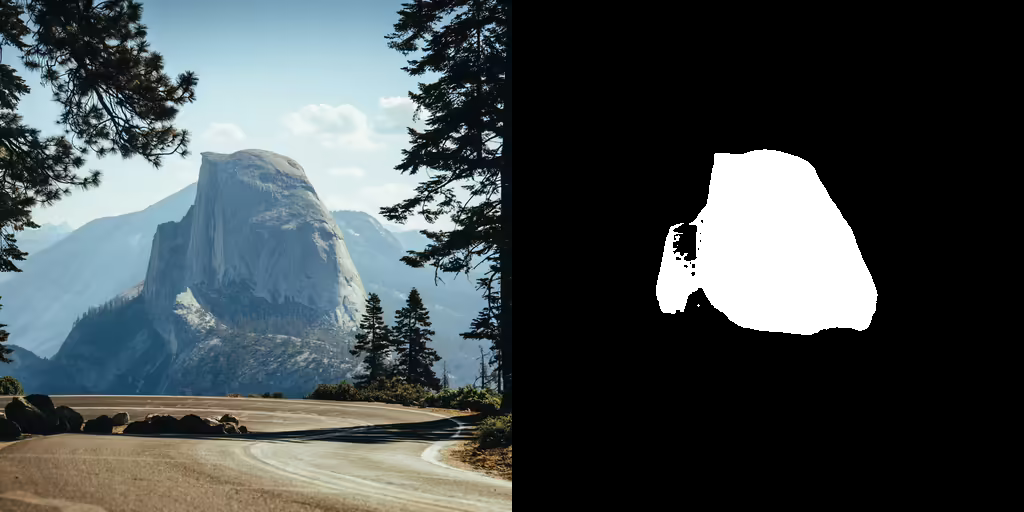

In [6]:
import openvino as ov
import numpy as np
from PIL import Image


def image_to_tensor(image: Image) -> ov.Tensor:
    pic = image.convert("RGB")
    image_data = np.array(pic.getdata()).reshape(1, pic.size[1], pic.size[0], 3).astype(np.uint8)
    return ov.Tensor(image_data)


init_image = Image.open(init_image_path)
init_image_tensor = image_to_tensor(init_image)

mask_image = Image.open(mask_path)
mask_image_tensor = image_to_tensor(mask_image)

make_image_grid([init_image, mask_image], rows=1, cols=2)

### Run inference pipeline
[back to top ⬆️](#Table-of-contents:)


For starting generation process, `generate` method should be used. Together with input prompt, mask and image, we also provided `generator`, pseudo-random numbers generator that responsible for results reproducibility. We will use `ov_genai.TorchGenerator` helper, the behavior of this generator is aligned with PyTorch. It means you can get result as much close to original diffusion pipeline as possible. `callback` argument allows early stopping generation if we decided that we are satisfied generation results when `num_inference_steps` has not been not reached yet, but it also can be useful for some other cases as well. In this tutorial, we will use it for adding interactive progress bar.

0it [00:00, ?it/s]

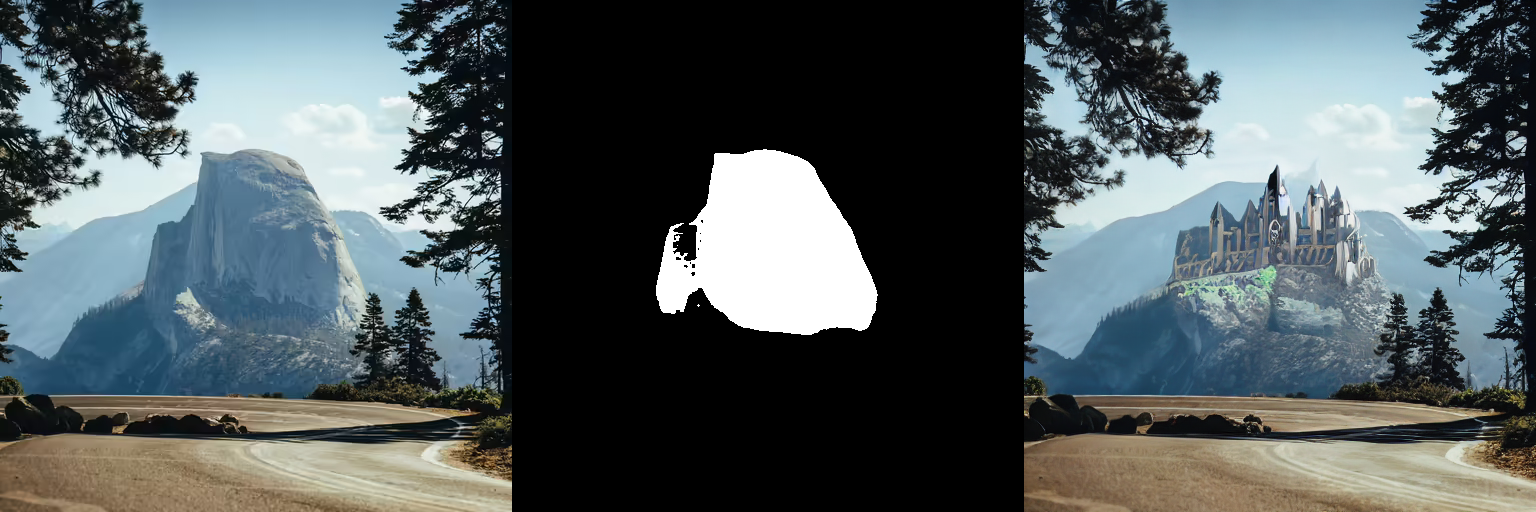

In [7]:
from tqdm.notebook import tqdm
import sys

generator = ov_genai.TorchGenerator(92)
prompt = "concept art digital painting of an elven castle, inspired by lord of the rings, highly detailed, 8k"

pbar = tqdm()


def callback(step, num_steps, latent):
    if pbar.total is None:
        pbar.reset(num_steps)
    pbar.update(1)
    sys.stdout.flush()
    return False


image_tensor = pipe.generate(prompt, init_image_tensor, mask_image_tensor, generator=generator, callback=callback, num_inference_steps=20)

pbar.close()
out_image = Image.fromarray(image_tensor.data[0])

make_image_grid([init_image, mask_image, out_image], rows=1, cols=3)

## Mask blur
[back to top ⬆️](#Table-of-contents:)


Mask blurring is useful technique for improving integration of modified area with original image. The code bellow demonstrates how to obtain mask with [Gaussian Blur](https://en.wikipedia.org/wiki/Gaussian_blur) and apply it for generation.

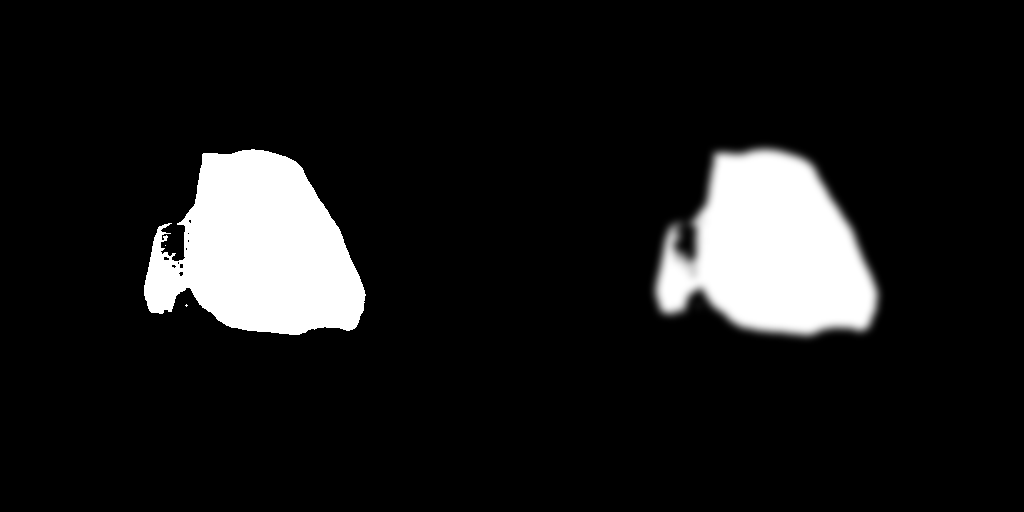

In [8]:
from PIL import ImageFilter


def blur(mask: Image, blur_factor: int = 4) -> Image:
    return mask.filter(ImageFilter.GaussianBlur(blur_factor))


blurred_mask_image = blur(mask_image, 4)

blurred_mask_tensor = image_to_tensor(blurred_mask_image)

make_image_grid([mask_image, blurred_mask_image], rows=1, cols=2)

0it [00:00, ?it/s]

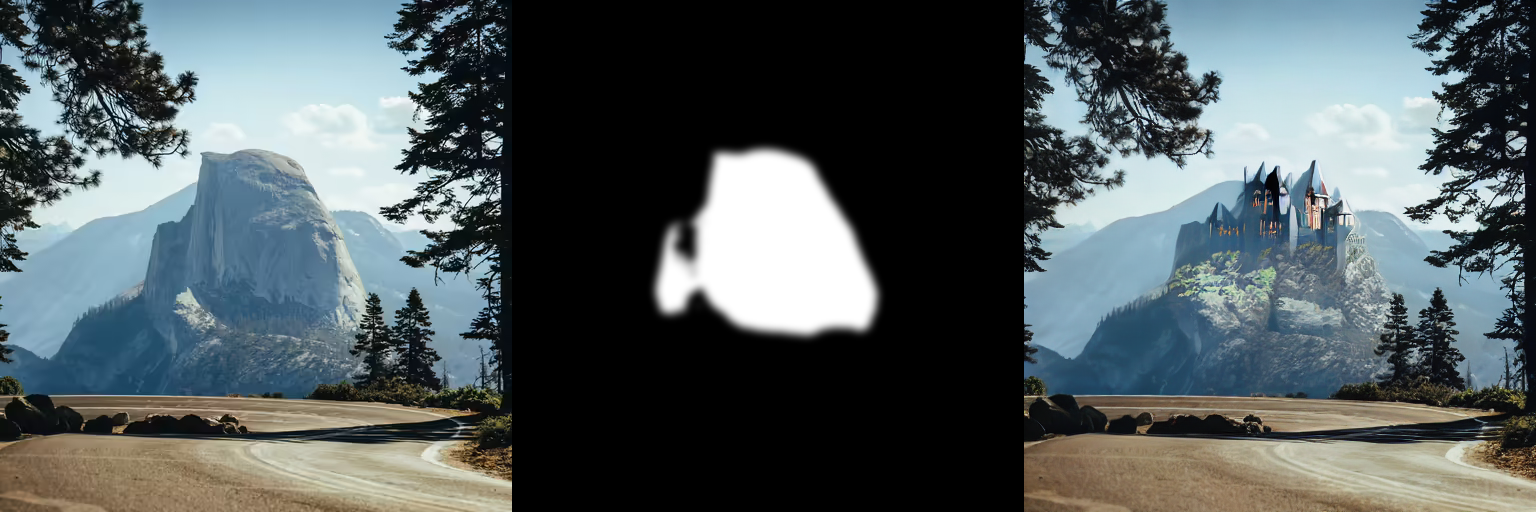

In [9]:
generator = ov_genai.TorchGenerator(92)

pbar = tqdm()

image_tensor = pipe.generate(prompt, init_image_tensor, blurred_mask_tensor, generator=generator, callback=callback, num_inference_steps=20)

pbar.close()
out_image = Image.fromarray(image_tensor.data[0])

make_image_grid([init_image, blurred_mask_image, out_image], rows=1, cols=3)

## Use non-inpaint specific models
[back to top ⬆️](#Table-of-contents:)


In this tutorial, we use [stable-diffusion-v1-5/stable-diffusion-inpainting](https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-inpainting) model, fine-tuned for inpainting Stable Diffusion 1.5 version, but `InpaingpingPipeline` also supports loading regular text-to-image models. Let’s compare the results of the two checkpoints. 

In [10]:
ov_model_id = "OpenVINO/stable-diffusion-v1-5-int8-ov"
hf_model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
model_dir = Path("stable-diffusion-v1-5-int8-ov")

if not model_dir.exists():
    !huggingface-cli download {ov_model_id} --local-dir {model_dir}

0it [00:00, ?it/s]

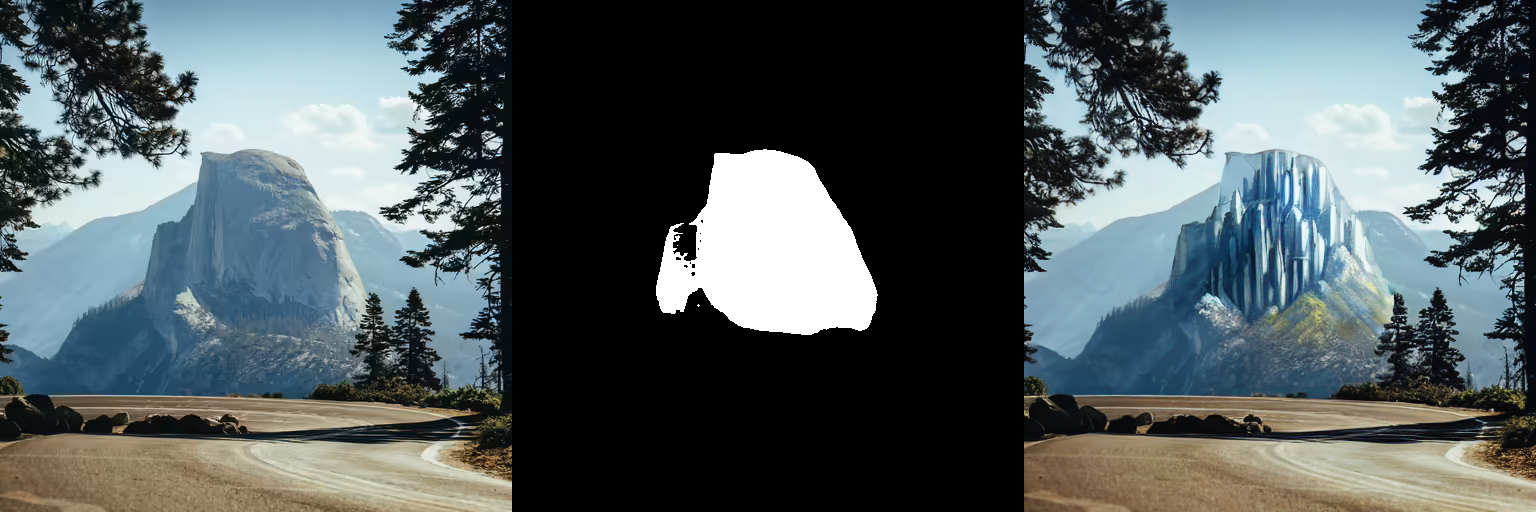

In [11]:
pipe = ov_genai.InpaintingPipeline(model_dir, device.value)
generator = ov_genai.TorchGenerator(92)
prompt = "concept art digital painting of an elven castle, inspired by lord of the rings, highly detailed, 8k"

pbar = tqdm()

image_tensor = pipe.generate(prompt, init_image_tensor, mask_image_tensor, generator=generator, callback=callback, num_inference_steps=20)

pbar.close()
out_image = Image.fromarray(image_tensor.data[0])

make_image_grid([init_image, mask_image, out_image], rows=1, cols=3)

However, for more basic tasks like erasing an object from an image (like the rocks in the road for example), a regular checkpoint yields pretty good results. There isn’t as noticeable of difference between the regular and inpaint checkpoint.

In [12]:
road_mask_path = Path("road_mask.png")

if not road_mask_path.exists():
    road_mask_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/road-mask.png")
    road_mask_image.save(road_mask_path)

road_mask_tensor = image_to_tensor(Image.open(road_mask_path))

generator = ov_genai.TorchGenerator(42)

0it [00:00, ?it/s]

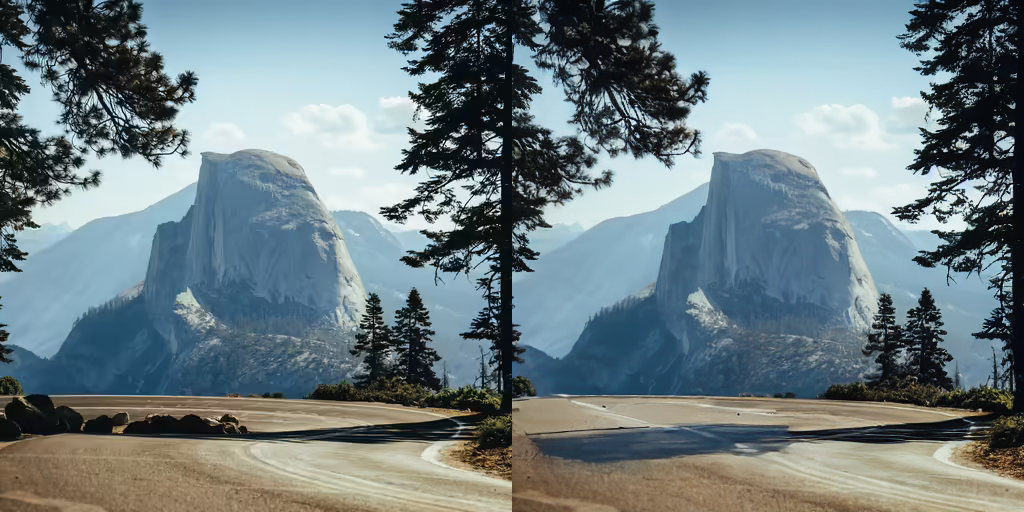

In [13]:
pbar = tqdm()

image_tensor = pipe.generate("road", init_image_tensor, road_mask_tensor, generator=generator, callback=callback, num_inference_steps=20)

pbar.close()
out_image = Image.fromarray(image_tensor.data[0])

make_image_grid([init_image, out_image], rows=1, cols=2)

## Configure pipeline parameters
[back to top ⬆️](#Table-of-contents:)


Image features - like quality and “creativity” - are dependent on pipeline parameters. Knowing what these parameters do is important for getting the results you want. Let’s take a look at the most important parameters and see how changing them affects the output.

### Strength
[back to top ⬆️](#Table-of-contents:)


`strength` is a measure of how much noise is added to the base image, which influences how similar the output is to the base image.

* 📈 a high strength value means more noise is added to an image and the denoising process takes longer, but you’ll get higher quality images that are more different from the base image
* 📉 a low strength value means less noise is added to an image and the denoising process is faster, but the image quality may not be as great and the generated image resembles the base image more
  
![](https://github.com/user-attachments/assets/745c849d-b7a0-4881-87d5-a4f3d450479d)

### Guidance Scale
[back to top ⬆️](#Table-of-contents:)

`guidance_scale` affects how aligned the text prompt and generated image are.

* 📈 a high guidance_scale value means the prompt and generated image are closely aligned, so the output is a stricter interpretation of the prompt
* 📉 a low guidance_scale value means the prompt and generated image are more loosely aligned, so the output may be more varied from the prompt

![](https://github.com/user-attachments/assets/1249e875-5e51-4309-8ba4-1d9b609e0976)

You can use `strength` and `guidance_scale` together for more control over how expressive the model is. For example, a combination high `strength` and `guidance_scale` values gives the model the most creative freedom.


### Negative prompt
[back to top ⬆️](#Table-of-contents:)


A negative prompt assumes the opposite role of a prompt; it guides the model away from generating certain things in an image. This is useful for quickly improving image quality and preventing the model from generating things you don’t want.

## Interactive demo
[back to top ⬆️](#Table-of-contents:)


Now, you can try inpainting capabilities on own images. Upload image or use one from provided examples, provide input text prompt and use brush button for starting drawing mask on top of input image. For start generation, please click `Inpaint` button. You also can adjust generation controlling parameters like `guidance_scale`, `streight`, `negative_prompt`, `num_inference_steps`, `seed` and mask processing using `Advanced Parameters` panel.

In [ ]:
if not Path("gradio_helper.py").exists():
    r = requests.get()
    with open("gradio_helper.py") as f:
        f.write(r.text)

from gradio_helper import make_demo

pipe = ov_genai.InpaintingPipeline(inpaint_model_dir, device.value)


demo = make_demo(pipe)

if __name__ == "__main__":
    demo.launch(debug=True)